# Autoencoder for credit card detection (Pytorch)

The objective of this exercice is to build a model able to detect fraudulous credit card transactions among normal transactions. For this we train a special type of neural network called autoencoder. This network has as many input nodes as output nodes, and several hidden layers with, usually lower dimensions.

The dataset we're going to use can be downloaded from [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud) (big file: 68 MB). It contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

All 30 features in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven't been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.

The dataset also contains the class of event: 0 = normal transaction; 1 = fraudulous transaction.

See example here:

* This example: https://github.com/curiousily/Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras/blob/master/fraud_detection.ipynb

* Another example: https://github.com/GitiHubi/deepAI/blob/master/GTC_2018_Lab.ipynb


## Initialize

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns

from sklearn.utils import shuffle

import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn

import sys
print(sys.version)
print(torch.version)
print('cuda:',torch.version.cuda)
print('\nRun on cpu')
dtype = torch.FloatTensor
device = torch.device("cpu")

3.10.16 (main, Dec 11 2024, 16:24:50) [GCC 11.2.0]
<module 'torch.version' from '/srv/conda/envs/notebook/lib/python3.10/site-packages/torch/version.py'>
cuda: 12.4

Run on cpu


## 1. Explore Data

a) Download the dataset and load it in a panda dataframe. Look at the first 10 examples.

b) Separate the data in two classes `normal` and `fraud`, then remove the class label from these datasets in order to conserve only the features.

c) Plot the first 5 features of both normal and fraud data (plotting all features is time consuming).

d) Split the `normal` dataset into a training and a test sample (each of same size).

After the last step you should have 3 datasets:
* normal data used for training
* normal data used for testing
* fraud data used for testing

In [2]:
# Load data

url = "https://cernbox.cern.ch/remote.php/dav/public-files/eebqSB1kYTMZ3Wm/creditcard.csv"
df = pd.read_csv(url)

# Print first 10 entries
print(df[:10])

# Get events for each class
#--------------------------
fraud  = df[df['Class']==1]  # Fraud
normal = df[df['Class']==0]  # Normal transactions

# Remove target (not needed)
drop=['Class']
fraud  = fraud.drop(columns=drop)
normal = normal.drop(columns=drop)

varname = list(normal)

# Split normal class in two parts (train and test)
x_train_normal,x_test_normal = train_test_split(normal.values,test_size=0.5,random_state=13)

# test fraud
x_test_fraud = fraud.values

print('x_train=', x_train_normal.shape,  'x_test_back=', x_test_normal.shape, 'x_test_signal=', x_test_fraud.shape)

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   
5   2.0 -0.425966  0.960523  1.141109 -0.168252  0.420987 -0.029728  0.476201   
6   4.0  1.229658  0.141004  0.045371  1.202613  0.191881  0.272708 -0.005159   
7   7.0 -0.644269  1.417964  1.074380 -0.492199  0.948934  0.428118  1.120631   
8   7.0 -0.894286  0.286157 -0.113192 -0.271526  2.669599  3.721818  0.370145   
9   9.0 -0.338262  1.119593  1.044367 -0.222187  0.499361 -0.246761  0.651583   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -

### Look at data

Original Images


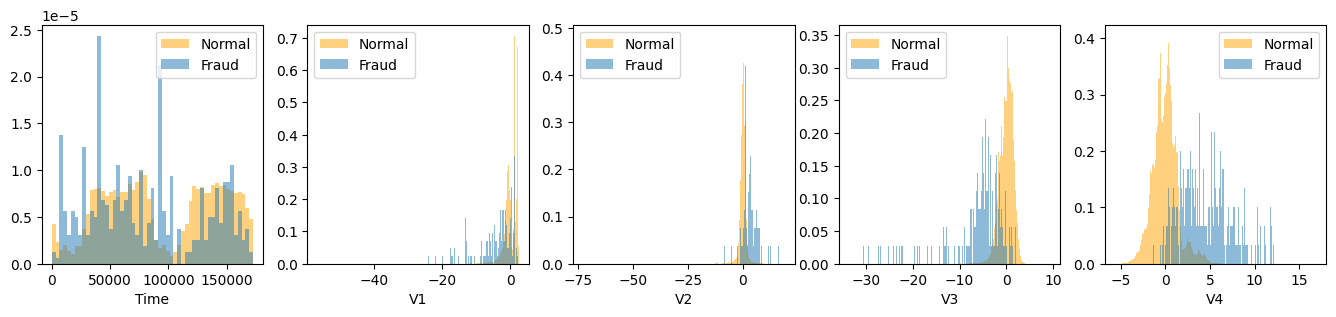

In [3]:
# Plotting original images
#bins = np.arange(-2, 2, 0.01)

print("Original Images")
plt.figure(figsize=(20, 18))
for i in range(5):
    plt.subplot(5, 6, i+1)
    n, bins, patches = plt.hist(x_test_normal[:,i], bins='auto', color = 'orange', alpha=0.5, label='Normal', density=1)
    plt.hist(x_test_fraud[:,i], bins, alpha=0.5, label='Fraud', density=1)
    plt.xlabel(varname[i])
    plt.legend(loc='best')

plt.savefig('AE_fraud_detection_original_variables_all.png')


## 2. Rescale data

Since features have different range we apply a transformation to each feature. For this we  use the MinMaxScaler that scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one:

See: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

a) Fit and transform the training dataset using the scaler with the `fit_transform` method.

b) Apply the transformation on the tests samples using the `transform` method.

c) Plot the first 5 features of the normal and fraud test data and see how they changed.

In [4]:
# Rescale data
#-------------
scaler = MinMaxScaler()

# fit (get min and max) and transform x_train
x_train_normal = scaler.fit_transform(x_train_normal)

# transform x_test (using scale parameters of x_train)
x_test_normal = scaler.transform(x_test_normal)
x_test_fraud = scaler.transform(x_test_fraud)

Rescaled Images


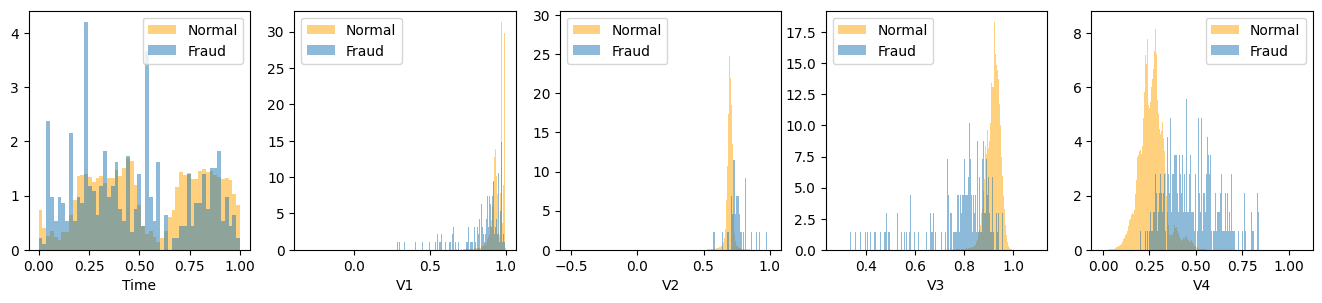

In [5]:
# Show variables after rescaling

print("Rescaled Images")
plt.figure(figsize=(20, 18))
for i in range(5):
    plt.subplot(5, 6, i+1)
    n, bins, patches = plt.hist(x_test_normal[:,i], bins='auto', color = 'orange', alpha=0.5, label='Normal', density=1)
    plt.hist(x_test_fraud[:,i], bins, alpha=0.5, label='Fraud', density=1)
    plt.xlabel(varname[i])
    plt.legend(loc='best')

plt.savefig('AE_fraud_detection_rescaled_variables_all.png')


## 3. Partition training data

After all of this, it's important to partition the data. In order for your model to generalize well, you split the training data into two parts: a training and a validation set. You will train your model on 80% of the data and validate it on 20% of the remaining training data.

In [6]:
x_train_train,x_train_valid = train_test_split(x_train_normal,test_size=0.2,random_state=13)
print(x_train_train.shape)
print(x_train_valid.shape)

(113725, 30)
(28432, 30)


## 4. AutoEncoder model

Now we create the AutoEncoder model.

Complete the network structure below using linear functions `nn.Linear(dim1,dim2)` (where `dim1` is the input dim of the layer and `dim2` the dimension of the layer output) and sigmoid activation functions `nn.Sigmoid()`:

a) in the encoding part create layers of dimension 30 (input) - 30 (hidden layer 1) - 25 (hidden layer 2) - 20 (latence space), each with a sigmoid activation function

b) in the decoding part create layers of dimension 25 (hidden layer 2) - 30 (hidden layer 1) - 30 (output) , where only the 1st layer has a sigmoid activation function

c) look at the forward function, what does it return ?

### Hyperparameters of the network

In [7]:
num_epochs = 200
batch_size = 2048
hidden_layer1 = 30
hidden_layer2 = 25
encoding_dim = 20

### AutoEncoder structure

In [8]:
input_dim = x_train_train.shape[1]

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_layer1),
            nn.Sigmoid(),
            nn.Linear(hidden_layer1, hidden_layer2),
            nn.Sigmoid(),
            nn.Linear(hidden_layer2, encoding_dim),
            nn.Sigmoid()
        )
        self.decoder = nn.Sequential(
            # EXERCISE: Can you try to build the decoder?
            # Hint: Think about the autoencoder structure!
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = autoencoder()
# Let's confirm that our model was build correctly
print(model)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=30, out_features=30, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=30, out_features=25, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=25, out_features=20, bias=True)
    (5): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=25, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=25, out_features=30, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=30, out_features=30, bias=True)
  )
)


## 5. Set the data loading utilities

We now call the [DataLoader](https://pytorch.org/docs/stable/data.html) constructors for the following datasets:
* normal data used for training
* normal data used for validation
* normal data used for testing
* fraud data used for testing

We shuffle the loading process of the train and validation datasets to make the learning process independent of data orderness, but the order of test datasets remains the same to examine whether we can handle unspecified bias order of inputs.

See how this is done below (you need to replace your own dataset names where appropriate).

In [9]:
# For training on normal samples
train_loader = torch.utils.data.DataLoader(dataset=x_train_train,
                                          batch_size=batch_size,
                                          shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=x_train_valid,
                                          batch_size=batch_size,
                                          shuffle=True)

# For testing on fraud examples (shuffle=False)
test_fraud_loader = torch.utils.data.DataLoader(dataset=x_test_fraud,
                                          batch_size=batch_size,
                                          shuffle=False)

# For testing on unseen normal sample (shuffle=False)
# EXERCISE: How can we define it?
# test_normal_loader = 

## 6. Training on normal samples

Run the training of the network on the training sample. For this complete the code below by answering the following questions:

a) Choose the mean square error loss function. See https://pytorch.org/docs/master/nn.html#loss-functions

b) Select the Adam optimizer (= minimization) method with a learning rate of 0.001. See https://pytorch.org/docs/stable/optim.html.

c) Fill the validation step knowing that it is the same structure as the training step but without the minimization part (not needed for validation).

d) Record for each epoch the loss value calculated for the training and validation steps. Make a figure of the training and validation losses as a function of the number of epochs. Do the two curve agree?


epoch [1/200], train loss:0.0094, validation loss:0.0089
epoch [50/200], train loss:0.0023, validation loss:0.0022
epoch [100/200], train loss:0.0023, validation loss:0.0023
epoch [150/200], train loss:0.0020, validation loss:0.0020
epoch [200/200], train loss:0.0018, validation loss:0.0018
Final train loss value: 0.0018


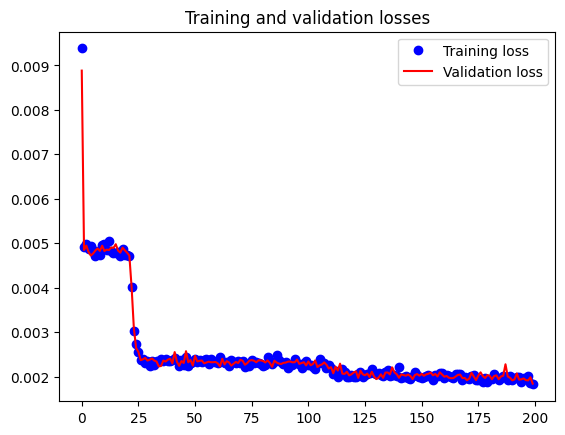

In [10]:
# Loss function: https://pytorch.org/docs/master/nn.html#loss-functions
criterion = nn.MSELoss()

# Optimizer: https://pytorch.org/docs/stable/optim.html
learning_rate = 0.001  # default is 0.001
l2_norm = 0

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay = l2_norm)

# Train
train_loss = []
valid_loss = []

for epoch in range(num_epochs):

    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data in train_loader:
        data = data.type(dtype)
        output = model(data)
        loss = criterion(output, data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # record train loss
    train_loss.append(loss.item())

    ######################
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data in valid_loader:
        data = data.type(dtype)
        output = model(data)
        loss = criterion(output, data)

    # record validation loss
    valid_loss.append(loss.item())

    if (epoch==0 or (epoch+1)%50==0):
        print('epoch [{}/{}], train loss:{:.4f}, validation loss:{:.4f}'.format(epoch + 1, num_epochs, train_loss[-1],valid_loss[-1]))

print('Final train loss value: %.4f' % train_loss[-1])

# Plot model performance
epochs = range(num_epochs)
plt.figure()
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, valid_loss, 'r-', label='Validation loss')
plt.title('Training and validation losses')
plt.legend()
plt.savefig('AE_fraud_loss.png')

## 7. Calculate autoencoder distances

Now we calculate the euclidean distance between the autoencoder input and output.

$$ \text{distance} = \sqrt{ ||x_{\text{input}} - x_{\text{output}}||^2} = \sqrt{ \sum_i (x^i_{\text{input}} - x^i_{\text{output}})^2}$$

a) See below how this is done for the normal test data, and do the same for the fraud test data.

b) Plot the histograms of the calculated distances of the normal and fraud test data. For better viewing choose a logarithmic scale for the y axis. Comment on the result.

In [11]:
model.eval() # Sets the module in evaluation mode.
model.cpu()  # Moves all model parameters and buffers to the CPU to avoid out of memory

# Normal test dataset
#--------------------
test_normal_distance = []
for data in test_normal_loader:
    data = data.type(dtype).cpu().detach()
    output = model(data)
    test_normal_distance += torch.sqrt((torch.sum((data-output)**2,axis=1)))

# convert list to tensor
test_normal_distance = torch.FloatTensor(test_normal_distance)

# convert tensor to numpy array
test_normal_distance = test_normal_distance.numpy()

# Fraud test dataset
#-------------------
test_fraud_distance = []
for data in test_fraud_loader:
    data = data.type(dtype).cpu().detach()
    output = model(data)
    test_fraud_distance += torch.sqrt((torch.sum((data-output)**2,axis=1)))

# convert list to tensor
test_fraud_distance = torch.FloatTensor(test_fraud_distance)

# convert tensor to numpy array
test_fraud_distance = test_fraud_distance.numpy()

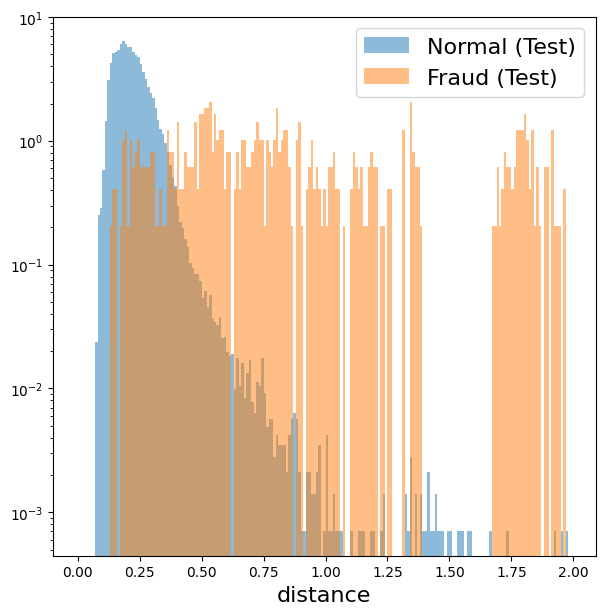

In [12]:
bins = np.arange(0, 2, 0.01)
plt.figure(figsize=(7, 7))
n, bins, patches = plt.hist(test_normal_distance, bins=bins, alpha=0.5, label='Normal (Test)', density=1, log=True)
plt.hist(test_fraud_distance, bins, alpha=0.5, label='Fraud (Test)', density=1)
plt.xlabel('distance',fontsize=16)
plt.legend(loc='upper right',fontsize=16)
plt.savefig("distances.png")

## 8. Confusion matrix

Build a confusion matrix with a threshold on the distance such that 50% of fraud transactions are detected. A confusion matrix is a table that summarizes the performance of a classification model by comparing its predicted labels to the true labels. It displays the number of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN) of the model's predictions. What is the true positive rate in this case? Is this threshold interesting?

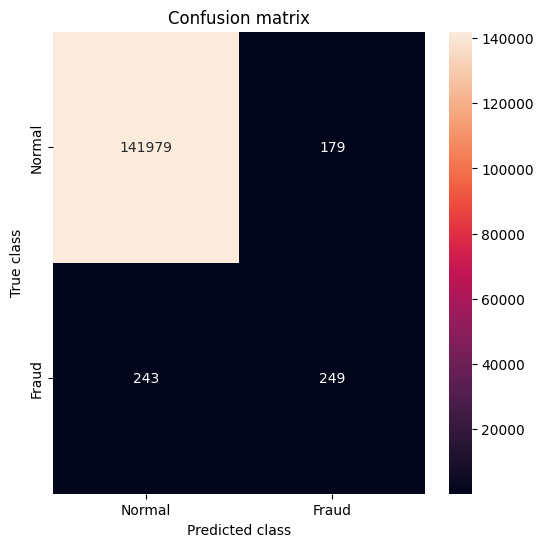

False positive rate = 0.13 %
True positive rate = 50.61 %


In [13]:
from sklearn.metrics import confusion_matrix

LABELS = ["Normal", "Fraud"]

target = np.concatenate((np.zeros(x_test_normal.shape[0]),np.ones(x_test_fraud.shape[0])))
scores = np.concatenate((test_normal_distance,test_fraud_distance))

threshold = 0.75

y_pred = [1 if e > threshold else 0 for e in scores]

# EXERCISE: Can you try to define the confusion matrix?
# conf_matrix = confusion_matrix(,)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

NN = conf_matrix[0,0] # True negative: Normal -> Normal
NF = conf_matrix[0,1] # False positive: Normal -> Fraud
FN = conf_matrix[1,0] # False negative: Fraud -> Normal
FF = conf_matrix[1,1] # True positive: Fraud -> Fraud

print('False positive rate = %.2f %%' % (NF/(NN+NF)*100))
print('True positive rate = %.2f %%' % (FF/(FN+FF)*100))

## 9. ROC Curve

Draw the ROC curve for the test sample.

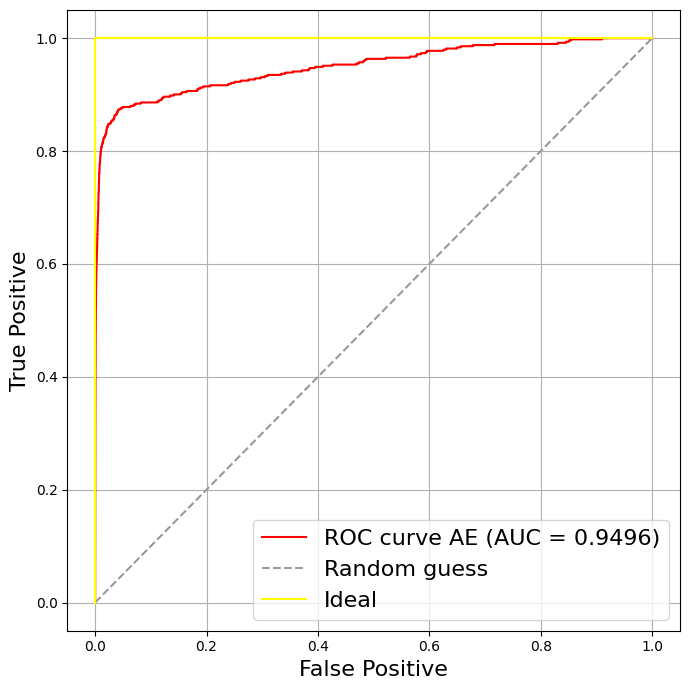

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict

target = np.concatenate((np.zeros(x_test_normal.shape[0]),np.ones(x_test_fraud.shape[0])))
scores = np.concatenate((test_normal_distance,test_fraud_distance))

plt.figure(figsize=(7, 7))

fp, vp, thresholds = roc_curve(target,scores,pos_label=1)
roc_auc = auc(fp, vp)

plt.plot(fp,vp,color='red',label='ROC curve %s (AUC = %0.4f)'%('AE',roc_auc))

plt.xlabel('False Positive',fontsize=16)
plt.ylabel('True Positive',fontsize=16)
plt.plot([0, 1],[0, 1],
         linestyle='--',color=(0.6, 0.6, 0.6),
         label='Random guess')
plt.plot([0, 0, 1],[0, 1, 1],color='yellow',label='Ideal')
plt.grid()
plt.legend(loc="best",fontsize=16)
plt.tight_layout()
plt.savefig("ROC.png")

# Further exercises

## 1) What if you vary the autoencoder dimensions?



## 2) How much effect can we see if we use another activation function?


## 3) What if you vary the fraction between test and validation?